# MNIST X RealNVP

## 2変量標準正規分布 -> MNIST


| |データサイズ|
|----| ----|
| 2変量標準正規分布 | 2|    
|MNIST | 28 x 28 x 1 |
|CIFER10| h x w x 3|
| Text | Seq_len x Embedding_size ? |

## Squeeze
入力を $h * w * c$ としたときに、その次元数を $\cfrac{h}{2} * \cfrac{w}{2} * 4c$ とする手法

すると、RealNVP のカップリングレイヤー上で、    
黒い部分が $x_a$ 白い部分が $x_b$ の役割を果たすようになる。

図では平面だが、3次元テンソルの場合も上から眺めることで、同様の平面として処理している。


※ $1 * 1 * c'$ 以降に変換を重ねたい場合の処理についてはおそらく未定義 (RealNVPの論文を読む限り)

## Multi-Scale Architecture
![](./multi-scale-arch.jpeg)

# Tensorflow を用いて解く

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
tfb = tfp.bijectors

print('tensorflow: ', tf.__version__)
print('tensorflow-probability: ', tfp.__version__)

tensorflow:  2.0.0-rc0
tensorflow-probability:  0.8.0-rc0


### 目標分布を作る

In [170]:
# Tensorflow の distribution を使う場合
z = tf.random.normal([2, 2, 256])
print('Tensorflow             : shape: {} mean: {:.6f} sd: {:.6f}'.format(z.shape, tf.math.reduce_mean(z), tf.math.reduce_std(z)))
# Tensorflow Probability の distribution を使う場合
target_dist = tfd.Normal(loc=0., scale=1.)
z = target_dist.sample([2, 2, 256])
print('Tensorflow Probability : shape: {} mean: {:.6f} sd: {:.6f}'.format(z.shape, tf.math.reduce_mean(z), tf.math.reduce_std(z)))

Tensorflow             : shape: (2, 2, 256) mean: -0.015819 sd: 0.964981
Tensorflow Probability : shape: (2, 2, 256) mean: 0.018457 sd: 0.984943


### 元分布(MNIST)データセットの作成

In [160]:
import os

# From tensorflow's BEGINNER TUTORIALS
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value.tobytes()]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""

return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [165]:
@tf.function
def _preprocess(x):
    x = tf.pad(x, paddings=[[0, 0], [2, 2], [2, 2]], mode="CONSTANT")
    x = tf.expand_dims(x, axis=-1)
    return x

def create_mnist():
    (train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()
    print('train_dataset: {} images'.format(train_x.shape[0]))
    print('test_dataset : {} images'.format(test_x.shape[0]))
    if not os.path.exists("mnists"):
        os.mkdir("mnists")

    def _serialize_example_pyfunction(img, label):
        feature = {
            "img": _bytes_feature(img.numpy()),
            "label": _int64_feature(label.numpy()),
        }
        example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
        return example_proto.SerializeToString()
    
    @tf.function
    def _gen_tf_serialize_example(img, label):
        tf_string = tf.py_function(
            _serialize_example_pyfunction, (img, label), tf.string
        )
        return tf.reshape(tf_string, ())

    def _save_features_dataset(save_to, feature_dataset):
        serialized_feature_dataset = train_features_dataset.map(
            _gen_tf_serialize_example
        )
        writer = tf.data.experimental.TFRecordWriter(save_to)
        writer.write(serialized_feature_dataset)

    train_x = _preprocess(train_x)
    train_features_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
    _save_features_dataset(os.path.join('mnists', 'train.tfrecord'), train_features_dataset)
    
    test_x = _preprocess(test_x)
    test_features_dataset = tf.data.Dataset.from_tensor_slices((test_x, test_y))
    _save_features_dataset(os.path.join('mnists', 'test.tfrecord'), test_features_dataset)

In [166]:
create_mnist()

train_dataset: 60000 images
test_dataset : 10000 images


#### データセットの確認

In [167]:
feature_description  = {
    'img': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.int64, default_value=0)
}

def _parse_function(example_proto):
    feature = tf.io.parse_single_example(example_proto, feature_description)
    img = tf.io.decode_raw(feature['img'], out_type=tf.uint8)
    img = tf.reshape(img, [32, 32, 1])
    img = tf.cast(img, dtype=tf.float32)
    img = (img / (255.0 / 2)) - 1
    feature['img'] = img
    return feature

In [168]:
filenames = [os.path.join('mnists', 'train.tfrecord')]
raw_dataset = tf.data.TFRecordDataset(filenames)
print(raw_dataset)
parsed_dataset = raw_dataset.map(_parse_function) 
print(parsed_dataset)

<TFRecordDatasetV2 shapes: (), types: tf.string>
<MapDataset shapes: {img: (32, 32, 1), label: ()}, types: {img: tf.float32, label: tf.int64}>


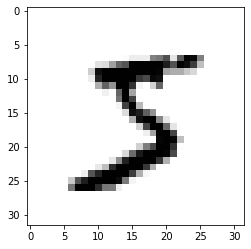

In [169]:
for image_features in parsed_dataset.take(1):
    plt.imshow(tf.squeeze(image_features['img'], axis=-1), cmap='gray_r')

### NN layer の作成
Glow に従ったNN Layerを作成する。公式のコードの https://github.com/openai/glow/blob/master/model.py#L420-L426 がおおよそこれに該当する。    
※ log_s, t の計算部分が本家とはやや異なっている点に注意

In [192]:
from tensorflow.keras.layers import Layer, BatchNormalization, ReLU, Conv2D
from tensorflow.keras import Model


class NN(Layer):
    def __init__(
        self,
        input_shape,
        n_hidden=[512, 512],
        kernel_size=[[3, 3], [1, 1]],
        strides=[[1, 1], [1, 1]],
        activation="relu",
        name="nn",
    ):
        super(NN, self).__init__(name="nn")
        layer_list = []
        for i, (hidden, kernel, stride) in enumerate(
            zip(n_hidden, kernel_size, strides)
        ):
            layer_list.append(
                Conv2D(
                    hidden,
                    kernel_size=kernel,
                    strides=stride,
                    activation=activation,
                    padding='SAME',
                    name="dense_{}_1".format(i),
                )
            )
            # In Glow,
            # layers.append Actnorm not BatchNormalization
            layer_list.append(BatchNormalization(trainable=True))
        self.layer_list = layer_list
        self.log_s_layer = Conv2D(
            input_shape,
            kernel_size=[3, 3],
            strides=[1, 1],
            padding='SAME',
            kernel_initializer="zeros",
            activation="tanh",
            name="log_s",
        )
        self.t_layer = Conv2D(
            input_shape,
            kernel_size=[3, 3],
            strides=[1, 1],
            padding='SAME',
            kernel_initializer="zeros",
            name="t",
        )

    def call(self, x):
        y = x
        for layer in self.layer_list:
            y = layer(y)
        log_s = self.log_s_layer(y)
        t = self.t_layer(y)
        return log_s, t


def nn_test():
    nn = NN(2, [256, 256])
    x = tf.keras.Input([16, 16, 2])
    log_s, t = nn(x)
    # Non trainable params: -> Batch Normalization's params
    tf.keras.Model(x, [log_s, t], name="nn_test").summary()


nn_test()

Model: "nn_test"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 16, 16, 2)]       0         
_________________________________________________________________
nn (NN)                      ((None, 16, 16, 2), (None 81924     
Total params: 81,924
Trainable params: 80,900
Non-trainable params: 1,024
_________________________________________________________________


In [194]:
nn = NN(2, [256, 256])
x = tf.random.normal([100, 16, 16, 2])
with tf.GradientTape() as t:
    t.watch(x)
    y = nn(x)
    loss = - tf.reduce_mean(y - x)
optimizer = tf.optimizers.Adam(learning_rate=0.0001) 
grads = t.gradient(loss, nn.trainable_variables)
optimizer.apply_gradients(zip(grads, nn.trainable_variables))
print(loss)

tf.Tensor(0.0022326293, shape=(), dtype=float32)


### RealNVP の Layer 作成
同様に Glow の実装に従って作成する。公式のコードの https://github.com/openai/glow/blob/master/model.py#L367-L383 がおおよそこれに該当する。

In [196]:
class RealNVP(tfb.Bijector):
    def __init__(
        self,
        input_shape,
        # this bijector do Tensor wise quantities. (I don't understand well...)
        forward_min_event_ndims=3,
        validate_args: bool = False,
        name="real_nvp",
        n_hidden=[512, 512],  
        **kargs,
    ):
        """
        Args:
            input_shape: 
                input_shape, 
                ex. [28, 28, 3] (image) [2] (x-y vector)
            forward_min_event_ndims:
                this bijector do 
                1. element-wize quantities => 0
                2. vector-wize quantities => 1
                3. matrix-wize quantities => 2
                4. tensor-wize quantities => 3
            n_hidden:
                see. class NN
            **kargs:
                see. class NN
                you can inuput NN's layers parameter here.
        """
        super(RealNVP, self).__init__(
            validate_args=validate_args, forward_min_event_ndims=forward_min_event_ndims, name=name
        )

        assert input_shape[-1] % 2 == 0
        self.input_shape = input_shape
        nn_layer = NN(input_shape[-1] // 2, n_hidden)
        nn_input_shape = input_shape.copy()
        nn_input_shape[-1] = input_shape[-1] // 2
        x = tf.keras.Input(nn_input_shape)
        log_s, t = nn_layer(x)
        self.nn = Model(x, [log_s, t], name="nn")

    def _forward(self, x):
        x_a, x_b = tf.split(x, 2, axis=-1)
        y_b = x_b
        log_s, t = self.nn(x_b)
        s = tf.exp(log_s)
        y_a = s * x_a + t
        y = tf.concat([y_a, y_b], axis=-1)
        return y

    def _inverse(self, y):
        y_a, y_b = tf.split(y, 2, axis=-1)
        x_b = y_b
        log_s, t = self.nn(y_b)
        s = tf.exp(log_s)
        x_a = (y_a - t) / s
        x = tf.concat([x_a, x_b], axis=-1)
        return x

    def _forward_log_det_jacobian(self, x):
        _, x_b = tf.split(x, 2, axis=-1)
        log_s, t = self.nn(x_b)
        return log_s


def realnvp_test():
    realnvp = RealNVP(input_shape=[16, 16, 4], n_hidden=[256, 256])
    x = tf.keras.Input([16, 16, 4])
    y = realnvp.forward(x)
    print('trainable_variables :', len(realnvp.trainable_variables))
    Model(x, y, name="realnvp_test").summary()


realnvp_test()

trainable_variables : 12
Model: "realnvp_test"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 16, 16, 4)]  0                                            
__________________________________________________________________________________________________
tf_op_layer_split_1 (TensorFlow [(None, 16, 16, 2),  0           input_19[0][0]                   
__________________________________________________________________________________________________
nn (Model)                      [(None, 16, 16, 2),  81924       tf_op_layer_split_1[0][1]        
__________________________________________________________________________________________________
tf_op_layer_Exp_1 (TensorFlowOp [(None, 16, 16, 2)]  0           nn[1][0]                         
______________________________________________________________

### Squeeze の Layer の作成

In [198]:
[32, 32, 3][-3:]

[32, 32, 3]

### Split Layer の作成
Split Layer では、channel 方向にデータを二分割して、片方を L 方向のループへ渡し、もう片方を $z_i$ とする。

これは既存の tensorflow probability の Blockwise bijector を用いることで代用する。

In [202]:
# 例
blockwise =tfb.Blockwise(
    bijectors=[tfb.Identity(), tfb.Exp()], block_sizes=[2, 2]
)


x = tf.keras.Input([16, 16, 4])
y = blockwise.forward(x)

tf.keras.Model(x, y).summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 16, 16, 4)]  0                                            
__________________________________________________________________________________________________
tf_op_layer_split_5 (TensorFlow [(None, 16, 16, 2),  0           input_23[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_Exp_4 (TensorFlowOp [(None, 16, 16, 2)]  0           tf_op_layer_split_5[0][1]        
__________________________________________________________________________________________________
tf_op_layer_concat_4 (TensorFlo [(None, 16, 16, 4)]  0           tf_op_layer_split_5[0][0]        
                                                                 tf_op_layer_Exp_4[0][0]    

### TransformedDistribution の作成

In [ ]:
num_realnvp = 4
bijector_chain = []
for i in range(num_realnvp):
    bijector_chain.append(RealNVP(input_shape=[32], n_hidden=[256, 256]))
    bijector_chain.append(tfp.bijectors.Permute([1, 0]))

flow = tfd.TransformedDistribution(
    distribution=mvn,
    bijector=tfb.Chain(list(reversed(bijector_chain)))
)
print('trainable_variables: ', len(flow.bijector.trainable_variables))